In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn

from flox.flock import Flock
from flox.learn.nn import FloxModule
from flox.run import federated_fit
from flox.utils.data import fed_barplot, federated_split
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor

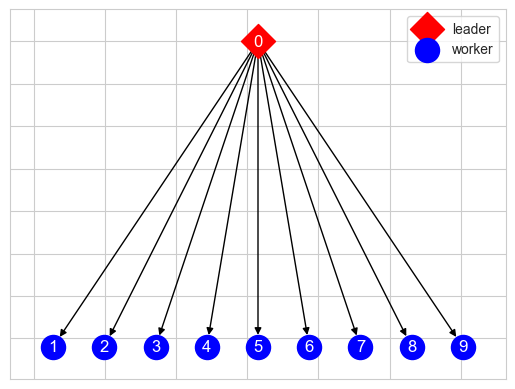

In [2]:
flock = Flock.from_yaml("examples/flocks/2-tier.yaml")
flock.draw()
plt.legend()
plt.show()

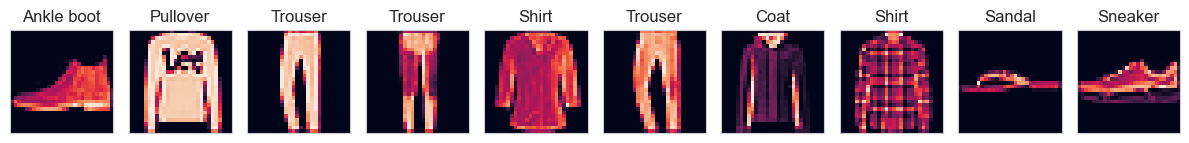

In [3]:
fashion_mnist = FashionMNIST(root=os.environ["TORCH_DATASETS"], download=False, train=False)
label_map = {
    0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
    5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot",
}

num = 10
fig, axes = plt.subplots(nrows=1, ncols=num, figsize=(12, 6))
for i, (image, label) in enumerate(fashion_mnist):
    axes[i].imshow(image)
    axes[i].set_title(label_map[label])
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    if i >= num - 1:
        break

plt.tight_layout()
plt.show()

# Data Distributions in Federated Settings
..


In [4]:
federated_data = federated_split(
    FashionMNIST(root=os.environ["TORCH_DATASETS"], download=False, train=True, transform=ToTensor()),
    flock,
    10,
    samples_alpha=1000.0,
    labels_alpha=1.0,
)

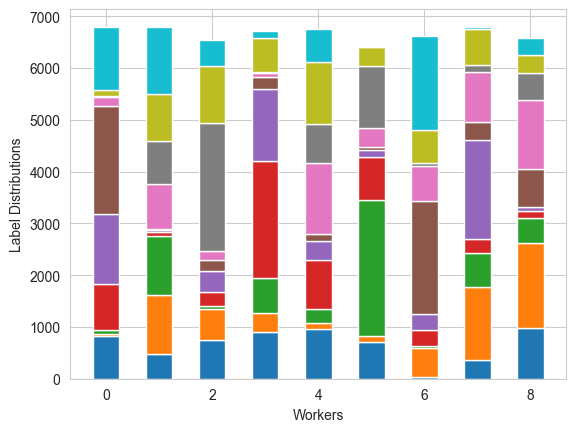

In [5]:
fed_barplot(federated_data, 10)
# plt.yscale("log")
plt.xlabel("Workers")
plt.ylabel("Label Distributions")
plt.show()

In [6]:
class MyModule(FloxModule):
    def __init__(self, lr: float = 0.01):
        super().__init__()
        self.lr = lr
        self.flatten = torch.nn.Flatten()
        self.linear_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.linear_stack(x)

    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        preds = self(inputs)
        loss = torch.nn.functional.cross_entropy(preds, targets)
        return loss

    def configure_optimizers(self) -> torch.optim.Optimizer:
        return torch.optim.SGD(self.parameters(), lr=self.lr)

In [7]:
df = federated_fit(
    flock,
    MyModule,
    federated_data,
    num_global_rounds=5,
    strategy="fedprox",
    kind="sync",
    where="local"
)
df.head()

federated_fit::sync: 100%|██████████| 5/5 [00:49<00:00,  9.81s/it]


,train/loss,train/epoch,train/batch_idx,train/time,node/idx,node/kind,parent/idx,parent/kind,round
0,2.331796,0,0,2023-10-04 11:22:59.300318,1,worker,0,leader,0
1,2.303255,0,1,2023-10-04 11:22:59.309160,1,worker,0,leader,0
2,2.308399,0,2,2023-10-04 11:22:59.316453,1,worker,0,leader,0
3,2.317670,0,3,2023-10-04 11:22:59.322673,1,worker,0,leader,0
4,2.296284,0,4,2023-10-04 11:22:59.331107,1,worker,0,leader,0


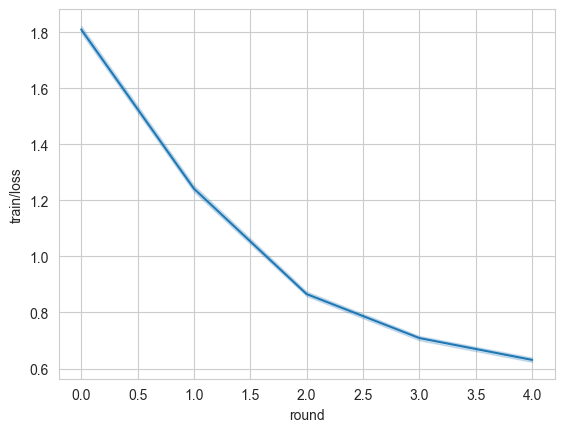

In [9]:
sns.lineplot(df, x="round", y="train/loss")
plt.show()